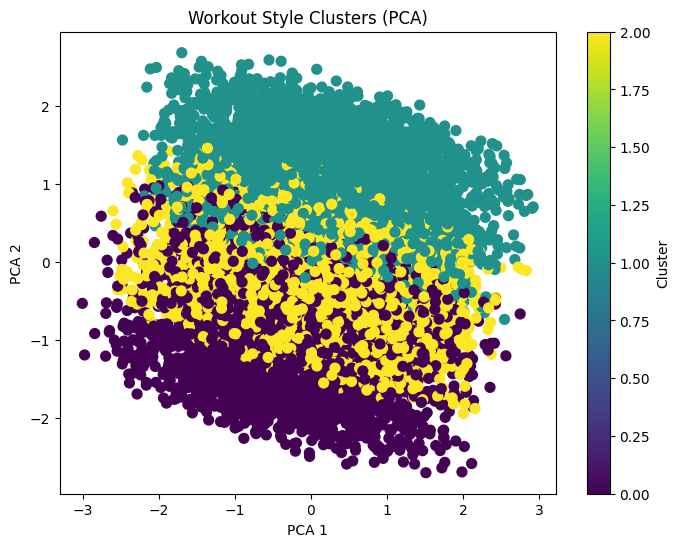

Silhouette Score: 0.1459388414365283

Cluster Behavioral Summary:
          Workout Duration (mins)  Calories Burned   Steps Taken  \
Cluster                                                           
0                      64.603370       546.737887  10358.446885   
1                      65.256957       778.906750  10370.093843   
2                      63.514095       325.265535  10640.700212   

         Workout Intensity  Sleep Hours  Water Intake (liters)  
Cluster                                                         
0                 2.000000     6.980409                    1.9  
1                 0.501184     6.979455                    1.9  
2                 0.504395     6.988694                    1.9  


In [ ]:
#phase 2
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Loading the dataset
df = pd.read_csv("workout_fitness_tracker_data.csv")

# selecting the features
features = ['Workout Duration (mins)',
            'Calories Burned',
            'Steps Taken',
            'Workout Intensity',
            'Sleep Hours',
            'Water Intake (liters)']

data = df[features].copy()

# Encoding the labels
if data['Workout Intensity'].dtype == 'object':
    le = LabelEncoder()
    data['Workout Intensity'] = le.fit_transform(data['Workout Intensity'])
    # Update the original df with the encoded values
    df['Workout Intensity'] = data['Workout Intensity']


# Scaling the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# using the clustering method
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df['Cluster'] = clusters

#pca reduction
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(data_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1],
            c=clusters, cmap='viridis', s=50)
plt.title("Workout Style Clusters (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.show()

sil_score = silhouette_score(data_scaled, clusters)
print("Silhouette Score:", sil_score)

#visualixation of the clusters
cluster_summary = df.groupby('Cluster')[features].mean()
print("\nCluster Behavioral Summary:\n", cluster_summary)

# Assigning labels
label_map = {
    0: 'Active',
    1: 'Lazy',
    2: 'Inconsistent'
}


In [1]:
#phase 1
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Loading the Dataset
df = pd.read_csv("workout_fitness_tracker_data.csv")

df['Dropout'] = (df['Workout Duration (mins)'] < 40).astype(int)

# 3. Separate features and labels
X = df.drop(columns=['User ID', 'Dropout'])  # drop User ID and target
y = df['Dropout']

# Identify categorical & numerical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)
input_dim = X_processed.shape[1]

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Convert to Torch tensors
X_train_t = torch.tensor(X_train.toarray() if hasattr(X_train, 'toarray') else X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test.toarray() if hasattr(X_test, 'toarray') else X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 6.dataloaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=64, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model = MLP(input_dim)

# 7. Training the model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_t)
        preds = (outputs >= 0.5).float()
        acc = accuracy_score(y_test, preds)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}")

# 8.evualying the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_t)
    preds = (outputs >= 0.5).float()
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

print("\nFinal Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Loss: 0.3834, Val Acc: 0.9755
Epoch [2/20], Loss: 0.0789, Val Acc: 0.9880
Epoch [3/20], Loss: 0.0455, Val Acc: 0.9885
Epoch [4/20], Loss: 0.0343, Val Acc: 0.9880
Epoch [5/20], Loss: 0.0274, Val Acc: 0.9890
Epoch [6/20], Loss: 0.0251, Val Acc: 0.9885
Epoch [7/20], Loss: 0.0203, Val Acc: 0.9895
Epoch [8/20], Loss: 0.0190, Val Acc: 0.9900
Epoch [9/20], Loss: 0.0169, Val Acc: 0.9895
Epoch [10/20], Loss: 0.0158, Val Acc: 0.9880
Epoch [11/20], Loss: 0.0130, Val Acc: 0.9925
Epoch [12/20], Loss: 0.0108, Val Acc: 0.9905
Epoch [13/20], Loss: 0.0095, Val Acc: 0.9900
Epoch [14/20], Loss: 0.0091, Val Acc: 0.9900
Epoch [15/20], Loss: 0.0096, Val Acc: 0.9920
Epoch [16/20], Loss: 0.0087, Val Acc: 0.9915
Epoch [17/20], Loss: 0.0069, Val Acc: 0.9925
Epoch [18/20], Loss: 0.0067, Val Acc: 0.9915
Epoch [19/20], Loss: 0.0057, Val Acc: 0.9890
Epoch [20/20], Loss: 0.0050, Val Acc: 0.9910

Final Evaluation:
Accuracy: 0.9910
Precision: 0.9832
Recall: 0.9832
F1 Score: 0.9832


In [3]:
# Phase 3:
import zipfile
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import re

#zip file upload
zip_path = "/content/journal workout.zip"  # <-- Name of the uploaded zip file
extract_dir = "datasets"

# Extract datasets if not already done
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Check contents
print("Extracted files:", os.listdir(extract_dir))


def load_data(path):
    data = []
    labels = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if ";" not in line:
                continue
            text, label = line.split(";")
            data.append(text.strip())
            labels.append(label.strip())
    return data, labels

train_file = os.path.join(extract_dir, "train.txt")
test_file = os.path.join(extract_dir, "test.txt")

train_texts, train_labels = load_data(train_file)
test_texts, test_labels = load_data(test_file)

print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")

# encodint the labels
label_set = sorted(list(set(train_labels)))
label2idx = {label: idx for idx, label in enumerate(label_set)}
idx2label = {idx: label for label, idx in label2idx.items()}

y_train = [label2idx[l] for l in train_labels]
y_test = [label2idx[l] for l in test_labels]

#preprocessing the text files
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

tokenized_train = [preprocess(t) for t in train_texts]
tokenized_test = [preprocess(t) for t in test_texts]

# Build vocabulary
word_counts = Counter()
for tokens in tokenized_train:
    word_counts.update(tokens)

vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab_size = len(vocab) + 1  # +1 for padding

print(f"Vocab size: {vocab_size}")

#limiting
MAX_LEN = 50

def encode(tokens):
    seq = [vocab.get(word, 0) for word in tokens]
    seq = seq[:MAX_LEN]
    seq += [0] * (MAX_LEN - len(seq))
    return seq

X_train = [encode(t) for t in tokenized_train]
X_test = [encode(t) for t in tokenized_test]
#train test split
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmotionDataset(X_train_tensor, y_train_tensor)
test_dataset = EmotionDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

#defining the model
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, output_dim=len(label_set)):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

model = EmotionLSTM(vocab_size=vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(y_batch.cpu().numpy())
    acc = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds, average="weighted")

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Val Acc: {acc:.4f}, Val F1: {f1:.4f}")

#testing the model by giving a sample from the dataset
def predict_emotion(sentence):
    model.eval()
    tokens = preprocess(sentence)
    encoded = torch.tensor([encode(tokens)], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(encoded)
        pred_idx = torch.argmax(output, dim=1).item()
    return idx2label[pred_idx]

print("\nSample Prediction:")
test_sentence = "I feel tired and unmotivated to continue my workouts."
print(test_sentence, "=>", predict_emotion(test_sentence))



Extracted files: ['test.txt', 'val.txt', 'train.txt']
Train size: 16000, Test size: 2000
Vocab size: 15213
Epoch 1/10, Loss: 1.5874, Val Acc: 0.3475, Val F1: 0.1836
Epoch 2/10, Loss: 1.5746, Val Acc: 0.3455, Val F1: 0.1828
Epoch 3/10, Loss: 1.5705, Val Acc: 0.3440, Val F1: 0.1819
Epoch 4/10, Loss: 1.5640, Val Acc: 0.3430, Val F1: 0.1854
Epoch 5/10, Loss: 1.5549, Val Acc: 0.3345, Val F1: 0.1987
Epoch 6/10, Loss: 1.5236, Val Acc: 0.3335, Val F1: 0.2272
Epoch 7/10, Loss: 1.4452, Val Acc: 0.4055, Val F1: 0.3310
Epoch 8/10, Loss: 1.1852, Val Acc: 0.4750, Val F1: 0.3730
Epoch 9/10, Loss: 0.9917, Val Acc: 0.5290, Val F1: 0.4344
Epoch 10/10, Loss: 0.8488, Val Acc: 0.5735, Val F1: 0.4815

Sample Prediction:
I feel tired and unmotivated to continue my workouts. => joy
